In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import os
import matplotlib.pyplot as plt
import numpy
import pandas
import tensorflow as tf
import seaborn

from kddcup_dataset import KDDCupDataset
from models import kdd_coembedded_lstm, kdd_embedded_lstm
from quick_experiment import utils
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import gensim

In [3]:
seaborn.set(style='white', rc={'figure.figsize':(11.7,8.27)})

In [4]:
def read_embedding_model(model_path):
    if model_path is None:
        return None
    return gensim.models.Word2Vec.load(model_path)

In [90]:
def get_outputs(model):
    sequence_output = []

    for iteration in range(5):
        feed_dict = model._fill_feed_dict('test')
        output = model.sess.run(model.state_op, feed_dict=feed_dict)
        for instance_index, (instance_output, instance, lenght, label) in enumerate(
                zip(output, feed_dict[model.instances_placeholder],
                    feed_dict[model.lengths_placeholder], feed_dict[model.labels_placeholder])):
            for time_step, (time_step_action, time_step_output) in enumerate(
                    zip(instance[:lenght], instance_output[:lenght])):
                sequence_output.append([
                    instance_index+(model.batch_size*iteration), time_step, time_step_output, time_step_action, label])

    return pandas.DataFrame(data=sequence_output, columns=['student', 'time_step', 'output', 'action', 'label'])

In [91]:
def graphic_students(vectors, student_ids, xcol='pca1', ycol='pca2', action_vectors=None, lines=True, annotate=False):
    for student in student_ids:
        student_sequence = vectors[vectors.student == student]
        if action_vectors is not None:
            used_actions = [int(x) for x in student_sequence.action.unique()]
            plt.scatter(action_vectors[used_actions,0], action_vectors[used_actions,1], marker='*',
                        c='black', s=200)
            for action_id in used_actions:
                plt.annotate(str(action_id), action_vectors[action_id])
        label = student_sequence.label.max()
        ax = plt.scatter(student_sequence[xcol].values, student_sequence[ycol].values, cmap='cool',
                         c=student_sequence.time_step.values, marker='x' if label == 1 else '.')
        if lines:
            plt.plot(student_sequence[xcol].values, student_sequence[ycol].values, lw=1)
        if annotate:
            for (action, x, y) in zip(student_sequence.action.values, 
                                      student_sequence[xcol].values, student_sequence[ycol].values):
                plt.annotate(str(int(action)), (x, y))
    plt.colorbar(label="Time")
    seaborn.despine()

# Full history models

In [116]:
course = 1
dataset_file = '../../data/kddcup2015/sequences/merged/c{}.p'.format(course)
embedding_file = '/home/mteruel/edm/data/kddcup2015/embeddings/word2vec/len_ge_5/c{}_20_merged_embeddings.model'.format(course)

embedding_model = read_embedding_model(embedding_file)
# embedding_model = None
dataset_config = {'train': 0.85, 'test': 1, 'validation': 0.15}
train_sequences, test_sequences, train_labels, test_labels = utils.pickle_from_file(dataset_file) 

kddcup_dataset = KDDCupDataset(embedding_model=embedding_model)
kddcup_dataset.create_fixed_samples(
    numpy.array([x[:,0] for x in train_sequences]), train_labels,
    numpy.array([x[:,0] for x in test_sequences]), test_labels,
    partition_sizes=dataset_config, samples_num=1)

kddcup_dataset.set_current_sample(0)

In [117]:
experiment_config = {
    'batch_size': 50,
    'hidden_layer_size': 20,
    'max_num_steps': 300,
    'dropout_ratio': 0.3,
    'embedding_model': embedding_model,
    'log_values': 50,
    'finetune_embeddings': True
}

model_dirname = '../../results/kddcup/coembedding/pretrained/tensorboard/18-01-26-20-05/c{}_run0/square'.format(course)
model_filename = os.path.join(model_dirname, 'model.ckpt-0')

tf.reset_default_graph()
model = kdd_coembedded_lstm.KDDCupCoEmbeddedLSTMModel(
    kddcup_dataset, logs_dirname=model_dirname, **experiment_config)

model.build_all()

model.load(model_filename)

In [118]:
vectors = get_outputs(model)
vectors.loc[:, 'Label'] = vectors.label.replace(
    to_replace=0, value='No Dropout').replace(to_replace=1, value='Dropout')

In [119]:
vectors.groupby('student').max()['Label'].reset_index().groupby('Label').count()

student
Label              
Dropout         181
No Dropout       69

In [120]:
action_embeddings = model.sess.run(model.embedding_var)

In [121]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numpy.vstack(vectors.output.values))

vectors['pca1'] = pca_result[:,0]
vectors['pca2'] = pca_result[:,1] 
# vectors['pca3'] = pca_result[:,2]

In [122]:
actions_pca = pca.transform(action_embeddings)

In [123]:
vectors[:10]

student  time_step                                             output  \
0        0          0  [0.0277467, -0.157501, 0.0807277, 0.0785369, -...   
1        0          1  [-0.128354, -0.33568, 0.289931, 0.0789842, -0....   
2        0          2  [-0.267927, -0.385914, 0.357715, 0.0313806, -0...   
3        0          3  [-0.27999, -0.383108, 0.454269, 0.0610399, -0....   
4        0          4  [-0.416479, -0.446415, 0.581711, 0.0334926, -0...   
5        0          5  [-0.490546, -0.463559, 0.546849, 0.00637392, -...   
6        0          6  [-0.490195, -0.398653, 0.588469, 0.0217399, -0...   
7        0          7  [-0.581218, -0.445961, 0.68969, 0.0151421, -0....   
8        0          8  [-0.599605, -0.426988, 0.642954, 0.0216472, -0...   
9        0          9  [-0.554717, -0.414674, 0.651999, 0.030344, -0....   

   action  label    Label      pca1      pca2  
0     1.0      1  Dropout  1.635742 -0.044182  
1    62.0      1  Dropout  1.318738 -0.120254  
2    29.0      1  Dropout  1.044155 -0.028089  
3     1.0      1  Dropout  0.836026  0.002595  
4    66.0      1  Dropout  0.627330  0.146735  
5    29.0      1  Dropout  0.484587  0.228105  
6     1.0      1  Dropout  0.410311  0.251822  
7    66.0      1  Dropout  0.266322  0.348769  
8    35.0      1  Dropout  0.290956  0.450184  
9     1.0      1  Dropout  0.295335  0.405825

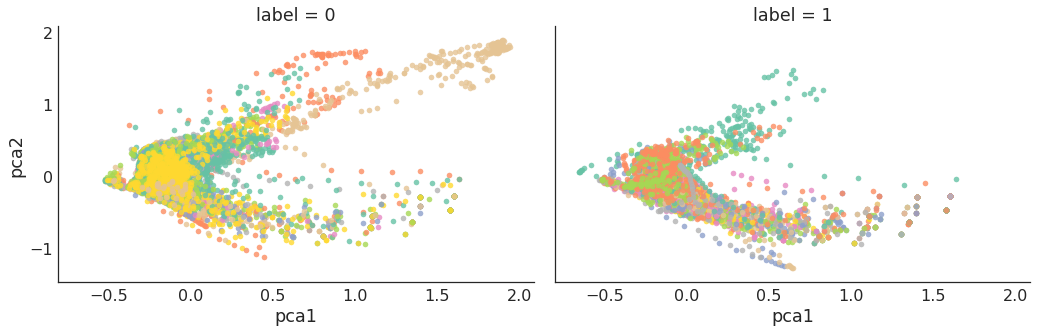

In [124]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

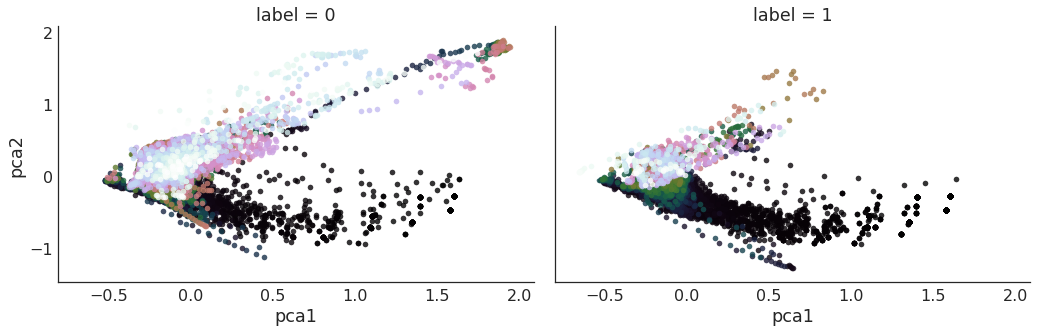

In [125]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

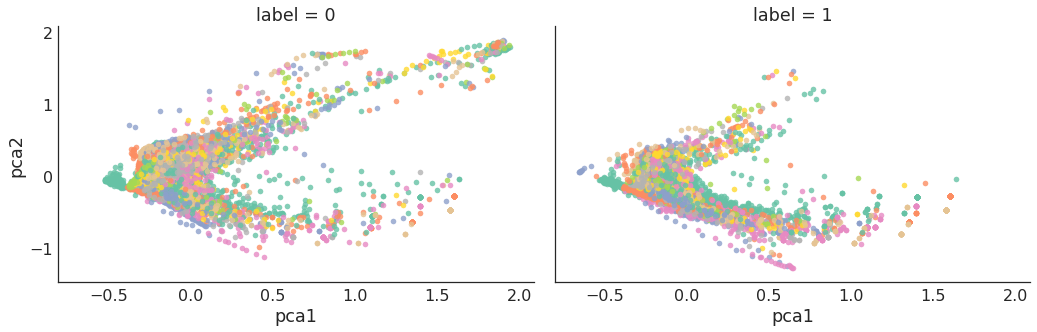

In [126]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

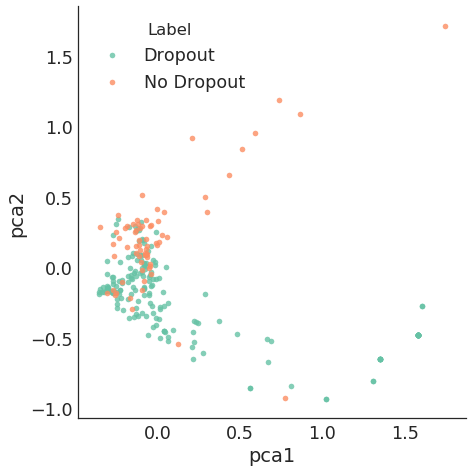

In [128]:
seaborn.set_context("paper", font_scale=2.2)
seaborn.lmplot(data=vectors.groupby('student').last(), x='pca1', y='pca2', hue='Label',
               fit_reg=False, size=7, palette='Set2', legend_out=False)

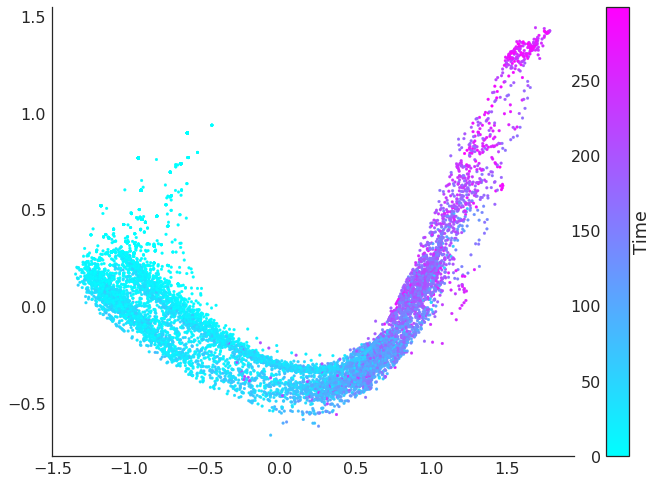

In [115]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.pca1.values, vectors.pca2.values, c=vectors.time_step.values, marker='.', cmap='cool')
plt.colorbar(label="Time")
# plt.scatter(actions_pca[used_actions,0], actions_pca[used_actions,1], marker='*', s=200)
# for action_id, point in enumerate(actions_pca):
#     if action_id in used_actions:
#         plt.annotate(str(action_id), point)
seaborn.despine()

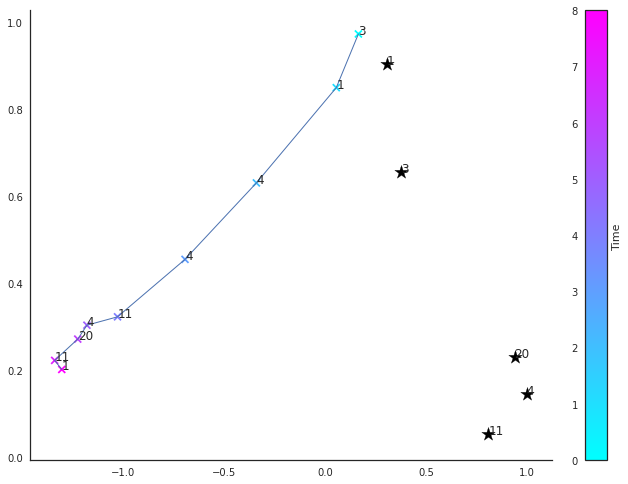

In [453]:
graphic_students(vectors, [50],  action_vectors=actions_pca, annotate=True)

In [439]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(numpy.vstack(vectors.output.values))

vectors['tsne1'] = tsne_results[:,0]
vectors['tsne2'] = tsne_results[:,1]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12647 samples in 0.014s...
[t-SNE] Computed neighbors for 12647 samples in 1.489s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12647
[t-SNE] Computed conditional probabilities for sample 2000 / 12647
[t-SNE] Computed conditional probabilities for sample 3000 / 12647
[t-SNE] Computed conditional probabilities for sample 4000 / 12647
[t-SNE] Computed conditional probabilities for sample 5000 / 12647
[t-SNE] Computed conditional probabilities for sample 6000 / 12647
[t-SNE] Computed conditional probabilities for sample 7000 / 12647
[t-SNE] Computed conditional probabilities for sample 8000 / 12647
[t-SNE] Computed conditional probabilities for sample 9000 / 12647
[t-SNE] Computed conditional probabilities for sample 10000 / 12647
[t-SNE] Computed conditional probabilities for sample 11000 / 12647
[t-SNE] Computed conditional probabilities for sample 12000 / 12647
[t-SNE] Computed conditional probabilities for sam

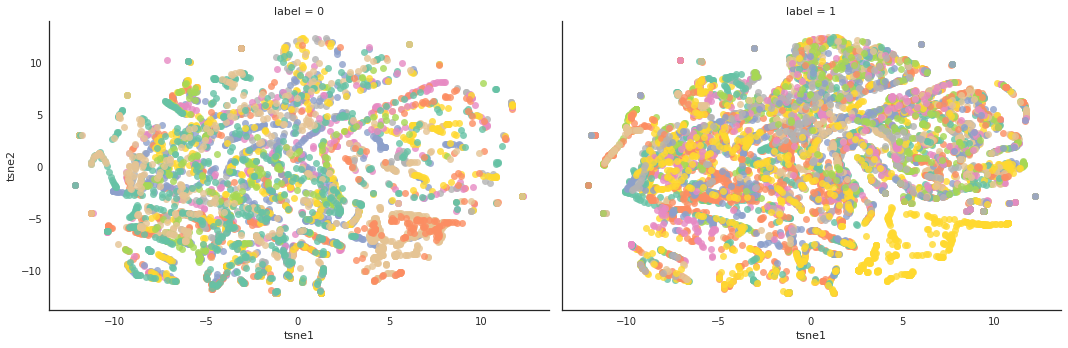

In [440]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

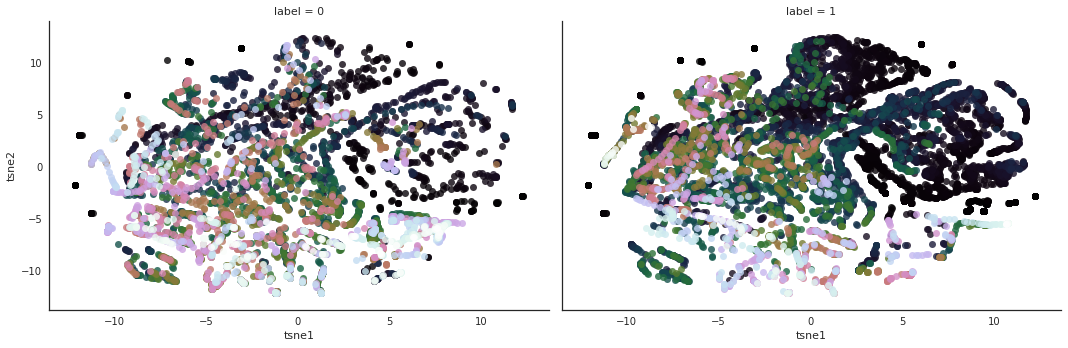

In [441]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

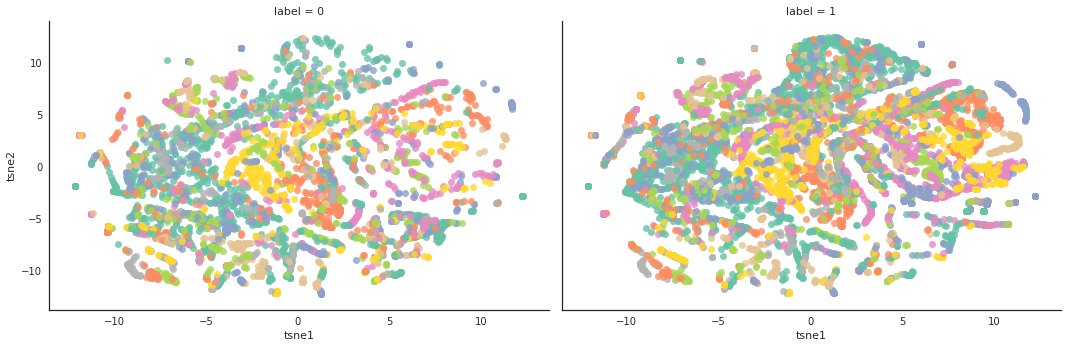

In [442]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

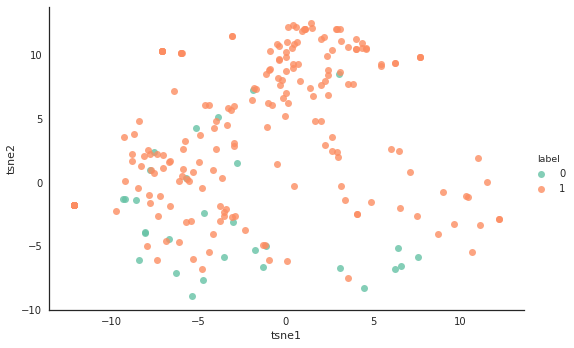

In [443]:
seaborn.lmplot(data=vectors.groupby('student').last(), x='tsne1', y='tsne2', hue='label',
               fit_reg=False, size=5, aspect=1.5, palette='Set2')

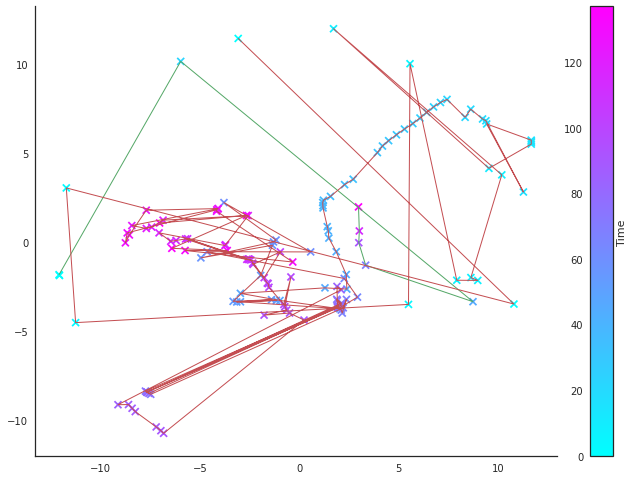

In [444]:
graphic_students(vectors, [17,14, 25], xcol='tsne1', ycol='tsne2')

IndexError: index 117 is out of bounds for axis 0 with size 113

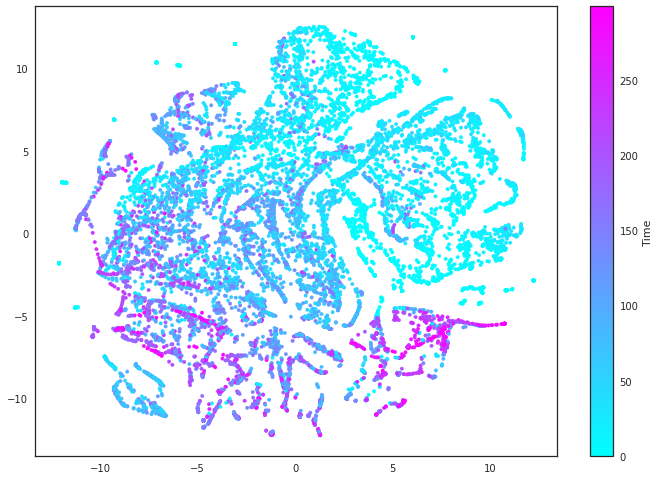

In [445]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.tsne1.values, vectors.tsne2.values, c=vectors.time_step.values, marker='.', cmap='cool')
plt.colorbar(label="Time")
plt.scatter(actions_tsne[used_actions,0], actions_tsne[used_actions,1], marker='*', s=200)
for action_id, point in enumerate(actions_tsne):
    if action_id in used_actions:
        plt.annotate(str(action_id), point)
seaborn.despine()

In [ ]:
for student in range(45,50):
    student_sequence = vectors[vectors.student == student]
    label = student_sequence.label.max()
    plt.plot(student_sequence.tsne1.values, student_sequence.tsne2.values, lw=2)
    plt.scatter(student_sequence.tsne1.values, student_sequence.tsne2.values, c=student_sequence.time_step.values,
                marker='o' if label == 1 else 'x')
plt.colorbar(label="Time")
seaborn.despine()

---
# Period-wise models

In [279]:
course = 1
period = 2
dataset_file = '../../data/kddcup2015/early_sequences/c{}_span7_period{}_merged.p'.format(course, period)

dataset_config = {'train': 0.85, 'test': 1, 'validation': 0.15}
train_df, test_df = utils.pickle_from_file(dataset_file)

period_kddcup_dataset = KDDCupDataset(embedding_model=None)
period_kddcup_dataset.create_fixed_samples(
    numpy.array([numpy.array(x)[:,0] for x in train_df.sequence.values]), train_df.dropout.values,
    numpy.array([numpy.array(x)[:,0] for x in test_df.sequence.values]), test_df.dropout.values,
    partition_sizes=dataset_config, samples_num=1)

period_kddcup_dataset.set_current_sample(0)

In [280]:
experiment_config = {
    'batch_size': 50,
    'hidden_layer_size': 50,
    'embedding_size': 50,
    'max_num_steps': 200,
    'dropout_ratio': 0.3,
    'embedding_model': None,
}

model_dirname = '../../results/kdd_early_dropout/embedded/tensorboard/18-01-17-19-14/c{}_p{}_run0/'.format(
    course, period)
model_filename = os.path.join(model_dirname, 'model.ckpt-0')

tf.reset_default_graph()
period_model = kdd_embedded_lstm.KDDCupEmbeddedLSTMModel(
    period_kddcup_dataset, logs_dirname=model_dirname, **experiment_config)

period_model.build_all()

period_model.load(model_filename)

In [281]:
action_embeddings = period_model.sess.run(period_model.embedding_var)

In [282]:
vectors = get_outputs(period_model)

In [283]:
vectors[:5]

student  time_step                                             output  \
0        0          0  [-0.158326, -0.0173856, 0.261892, 0.0642346, 0...   
1        0          1  [-0.124058, -0.00924223, 0.418266, 0.0922022, ...   
2        0          2  [-0.0714937, -0.0189051, 0.466754, 0.0747918, ...   
3        0          3  [-0.159174, -0.0266042, 0.545738, 0.11902, 0.2...   
4        0          4  [-0.10002, -0.0451698, 0.552238, 0.106395, 0.2...   

   action  label  
0    98.0      0  
1     2.0      0  
2   101.0      0  
3   102.0      0  
4   103.0      0

In [284]:
vectors.groupby('student').max()['label'].reset_index().groupby('label').count()

student
label         
0           68
1          182

In [285]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numpy.vstack(vectors.output.values))

vectors['pca1'] = pca_result[:,0]
vectors['pca2'] = pca_result[:,1] 

In [286]:
actions_pca = pca.transform(action_embeddings)

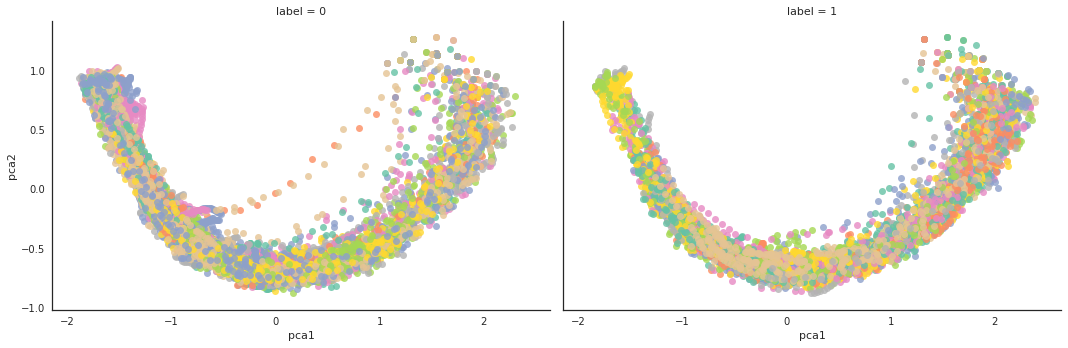

In [287]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

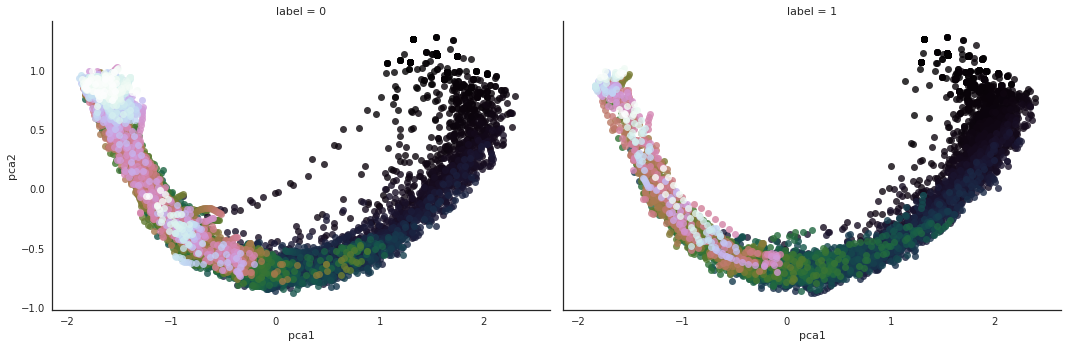

In [288]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

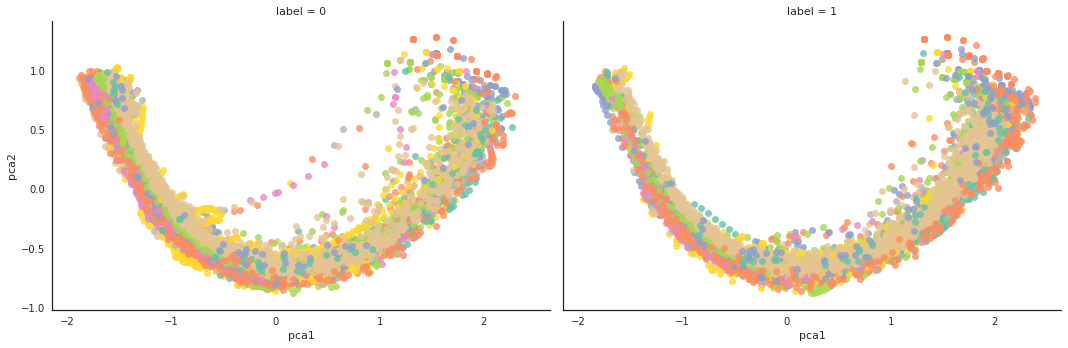

In [289]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

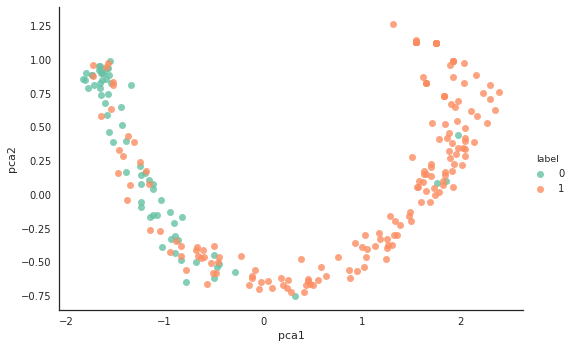

In [290]:
seaborn.lmplot(data=vectors.groupby('student').last(), x='pca1', y='pca2', hue='label',
               fit_reg=False, size=5, aspect=1.5, palette='Set2')

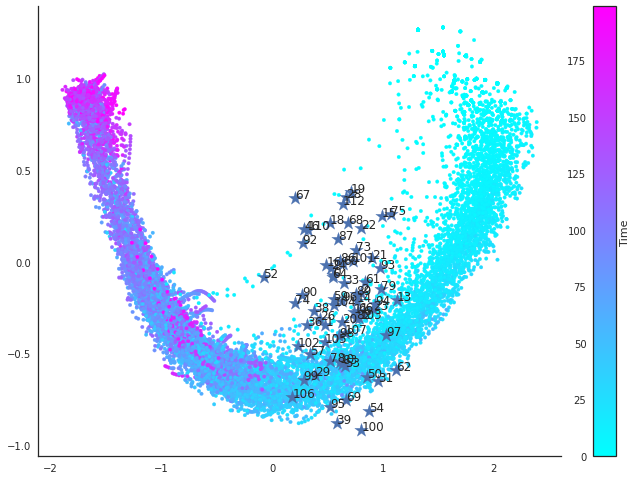

In [291]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.pca1.values, vectors.pca2.values, c=vectors.time_step.values, marker='.', cmap='cool')
plt.colorbar(label="Time")
plt.scatter(actions_pca[used_actions,0], actions_pca[used_actions,1], marker='*', s=200)
for action_id, point in enumerate(actions_pca):
    if action_id in used_actions:
        plt.annotate(str(action_id), point)
seaborn.despine()

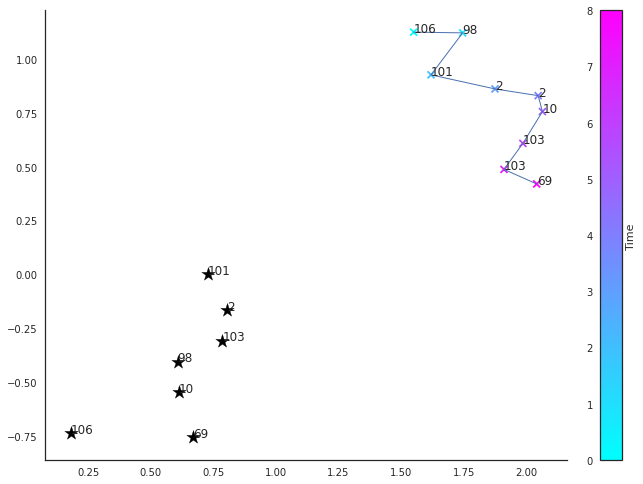

In [292]:
graphic_students(vectors, [6], annotate=True, action_vectors=actions_pca)

In [293]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(numpy.vstack([numpy.vstack(vectors.output.values), action_embeddings]))

vectors['tsne1'] = tsne_results[:vectors.shape[0],0]
vectors['tsne2'] = tsne_results[:vectors.shape[0],1]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 14611 samples in 0.024s...
[t-SNE] Computed neighbors for 14611 samples in 3.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14611
[t-SNE] Computed conditional probabilities for sample 2000 / 14611
[t-SNE] Computed conditional probabilities for sample 3000 / 14611
[t-SNE] Computed conditional probabilities for sample 4000 / 14611
[t-SNE] Computed conditional probabilities for sample 5000 / 14611
[t-SNE] Computed conditional probabilities for sample 6000 / 14611
[t-SNE] Computed conditional probabilities for sample 7000 / 14611
[t-SNE] Computed conditional probabilities for sample 8000 / 14611
[t-SNE] Computed conditional probabilities for sample 9000 / 14611
[t-SNE] Computed conditional probabilities for sample 10000 / 14611
[t-SNE] Computed conditional probabilities for sample 11000 / 14611
[t-SNE] Computed conditional probabilities for sample 12000 / 14611
[t-SNE] Computed conditional probabilities for sam

In [294]:
actions_tsne = tsne_results[vectors.shape[0]:]

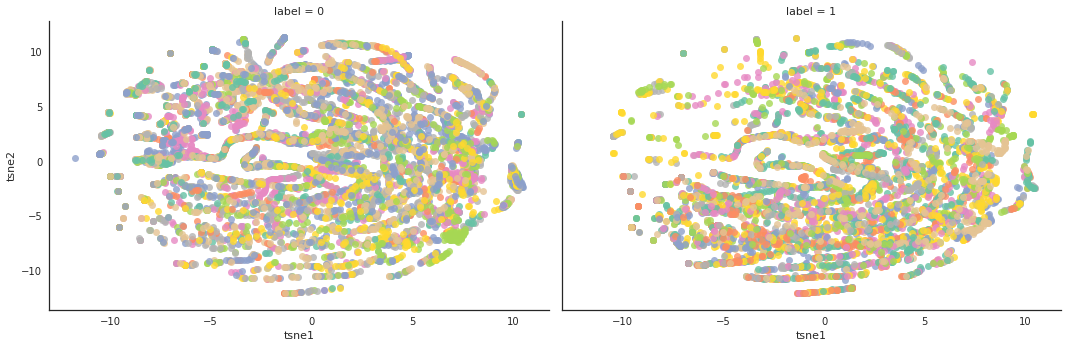

In [295]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

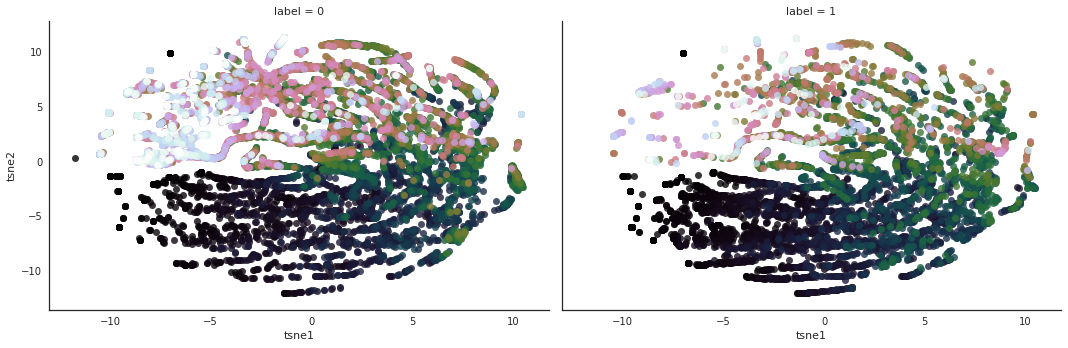

In [296]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

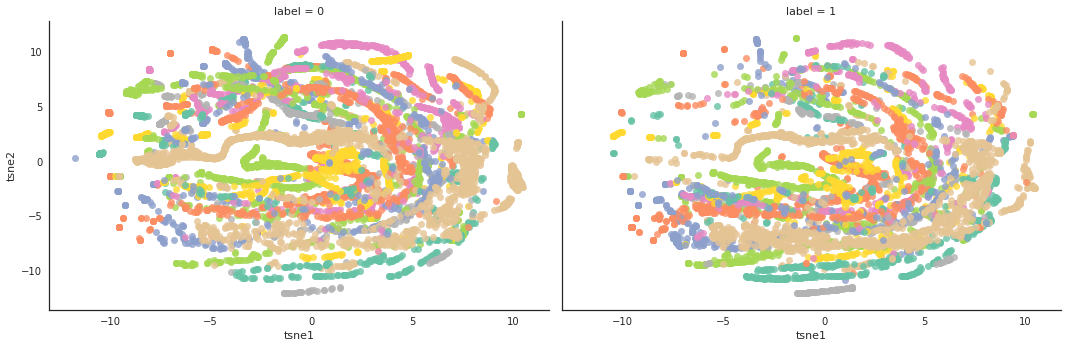

In [297]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

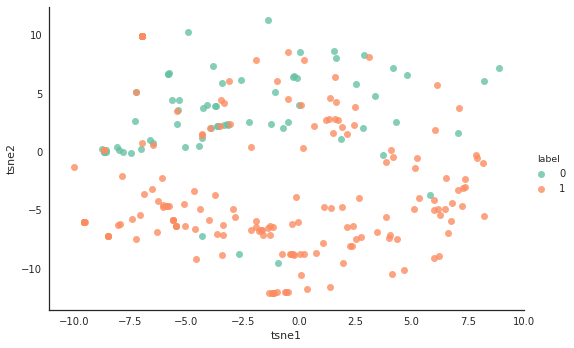

In [298]:
seaborn.lmplot(data=vectors.groupby('student').last(), x='tsne1', y='tsne2', hue='label',
               fit_reg=False, size=5, aspect=1.5, palette='Set2')

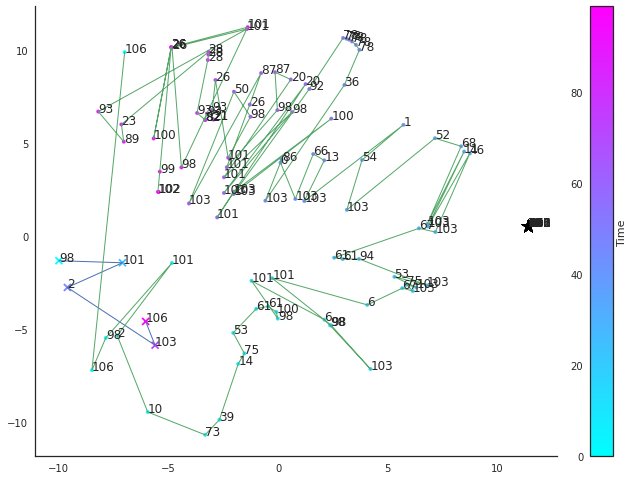

In [305]:
graphic_students(vectors, [17,14], xcol='tsne1', ycol='tsne2', annotate=True, action_vectors=actions_tsne)

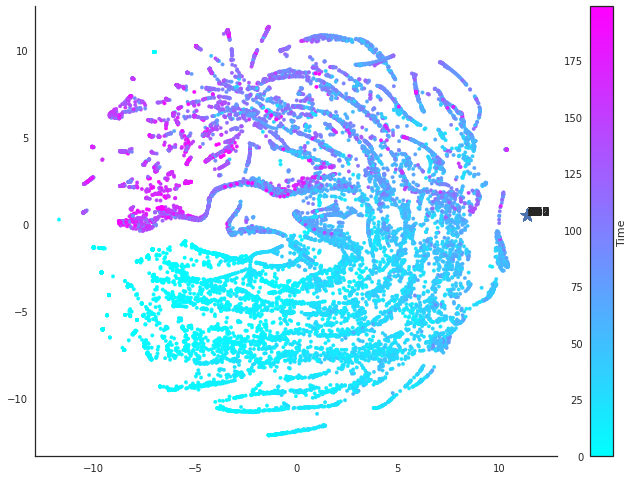

In [300]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.tsne1.values, vectors.tsne2.values, c=vectors.time_step.values, marker='.', cmap='cool')
plt.colorbar(label="Time")
plt.scatter(actions_tsne[used_actions,0], actions_tsne[used_actions,1], marker='*', s=200)
for action_id, point in enumerate(actions_tsne):
    if action_id in used_actions:
        plt.annotate(str(action_id), point)
seaborn.despine()